# Project - Credit Card Fraud Detection - SVM Kernel Selection

Ad Soyad: Önder Görmez  
Öğrenci No: 21501035

# Aims of the Project
* Bu projede, veri setinde nadir olarak karşılaşılan ama aslında tespit etmeye çalıştığımız bir durum olan kredi kartı dolandırıcılığının tespiti üzerine yapılmış geçmiş çalışmalar incelenecektir.  
* Dersin ana konusu olan **klasik makine öğrenmesi** konularına odaklanılacak ve bu konuların kredi kartı dolandırıcılığı tespiti üzerindeki etkileri incelenecektir.

# Logger Kullanımı

- Oluşturulan kod içerisinde loglama işlemleri için `logging` kütüphanesi kullanılmıştır.
- Böylelikle geliştirme aşamasında debug için koyulan kodların çıktılarına bakılarak hata ayıklama işlemleri yapılabilir. Bu kodların çıktıları rapor sunulurken kaldırılacaktır.


In [1]:
import logging
import logging.config
import yaml
import textwrap

class CustomFormatter(logging.Formatter):

    def format(self, record):
        wrapped_message = super().format(record)

        # wrap the log messages to 120 characters to better fit the screen
        if (len(wrapped_message) > 120):
            wrapped_message = "\n".join(textwrap.wrap(wrapped_message, width=120))

            # indent the wrapped lines but not the first line
            first_line, rest = wrapped_message.split('\n', 1)
            wrapped_message = first_line + '\n' + textwrap.indent(rest, ' ' * 4) + '\n'

        return wrapped_message

PROJECT_DIR = '/Users/ondergormez/Repos/BLM5110_Machine_Learning/03-Project/'
LOGGER_CONFIG_FILE = PROJECT_DIR + 'logger_config.yaml'

# Load the YAML configuration
with open('logger_config.yaml', 'r') as file:
    config = yaml.safe_load(file.read())
    logging.config.dictConfig(config)

# Apply the custom formatter to the selected handler
logger = logging.getLogger("default_logger")
for handler in logger.handlers:
    if isinstance(handler, logging.StreamHandler):
        handler.setFormatter(CustomFormatter(handler.formatter._fmt, datefmt=handler.formatter.datefmt))

# TODO: Set the log level to INFO
logger.setLevel(logging.DEBUG)


logger.debug("This is a debug message that will be wrapped after 140 characters. " * 10)
logger.info("Logging is configured successfully.")

[DEBUG] [2025-01-04T23:50:47.681Z] This is a debug message that will be wrapped after 140 characters. This is a debug
    message that will be wrapped after 140 characters. This is a debug message that will be wrapped after 140 characters.
    This is a debug message that will be wrapped after 140 characters. This is a debug message that will be wrapped after
    140 characters. This is a debug message that will be wrapped after 140 characters. This is a debug message that will be
    wrapped after 140 characters. This is a debug message that will be wrapped after 140 characters. This is a debug message
    that will be wrapped after 140 characters. This is a debug message that will be wrapped after 140 characters.

[INFO] [2025-01-04T23:50:47.682Z] Logging is configured successfully.


# Dataset Selection

Konu ile ilgili datasetler incelendiğinde okunacak makaleninde incelediği [Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data) dataseti üzerinde çalışılması uygun görülmüştür. 

* Bu dataset, 2013 yılında Avrupa'da 2 günde gerçekleşen kredi kartı işlemlerini içermektedir. Toplamda 284.807 işlem bulunmaktadır ve bu işlemlerden 492 tanesi dolandırıcılık içermektedir. Bu da **%0.172 dolandırıcılık oranına** denk gelmektedir.
* Bu dataset, **dengesiz (highly unbalanced)** bir datasettir ve dolandırıcılık işlemleri nadir olarak gerçekleşmektedir.
* Bu nedenle, bu dataset üzerinde çalışmak, kredi kartı dolandırıcılığı tespiti üzerindeki zorlukları daha iyi anlamamıza yardımcı olacaktır.

## Dataset Features

Veri setinin temel özellikleri;
* **Size:** 150.83 MB
* creditcard.csv
* Avrupa'da 2013 yılında yapılan işlemleri içerir
* 2 gün içinde gerçekleşen işlemler
* 284315 transfer içinde 492 fraud transfer
* Yüksek dengesizlik oranı (highly unbalanced)
* Yüzde 0.172 fraud transfer

# Dataset'in Yüklenmesi

[Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data) dataseti indirilerek proje klasörüne koyulmuştur. Aşağıdaki şekilde projeye dahil edilmiştir.

* **V1, V2, ... V28** özellikleri, PCA ile elde edilen ana bileşenlerdir.
* PCA ile dönüştürülmeyen tek özellik 'Time' ve 'Amount' özellikleridir. 
  * **'Time' özelliği**, her işlem arasındaki geçen saniyeleri ve veri kümesindeki ilk işlem arasındaki saniyeleri içerir.
  * **'Amount' özelliği**, işlem miktarıdır, bu özellik 'example-dependant cost-sensitive learning' için kullanılabilir.
* **'Class' özelliği** yanıt değişkenidir ve **dolandırıcılık durumunda 1** değerini alır, **aksi takdirde 0** değerini alır.


In [2]:
import pandas as pd

FILE_PATH = PROJECT_DIR + 'creditcard.csv'

raw_data_df = pd.read_csv(FILE_PATH, sep=',')

logger.info("Columns of the raw dataframe: " + str(raw_data_df.columns))

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))
raw_data_df.head()

[INFO] [2025-01-04T23:50:48.629Z] Columns of the raw dataframe: Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7',
    'V8', 'V9', 'V10',        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',        'V21', 'V22',
    'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',        'Class'],       dtype='object')

[INFO] [2025-01-04T23:50:48.629Z] Shape of the dataframe: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Visualizing the Dataset Via Pie Chart

[INFO] [2025-01-04T23:50:48.757Z] Non-Fraud Transactions: 284315
[INFO] [2025-01-04T23:50:48.757Z] Fraud Transactions: 492


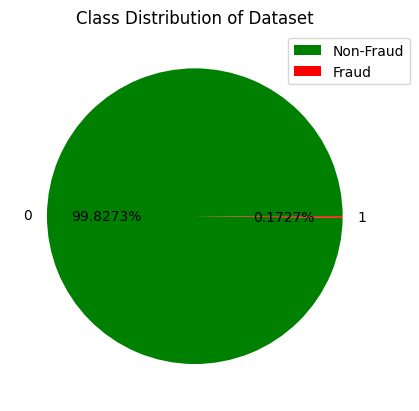

In [3]:
import matplotlib.pyplot as plt

class_column = 'Class'
class_counts = raw_data_df[class_column].value_counts()

# Class 0: Non-Fraud, Class 1: Fraud
logger.info("Non-Fraud Transactions: " + str(class_counts[0]))
logger.info("Fraud Transactions: " + str(class_counts[1]))

colors = ['green', 'red']
class_counts.plot.pie(autopct='%1.4f%%', startangle=0, colors=colors)
plt.title('Class Distribution of Dataset')
plt.ylabel('')
plt.legend(['Non-Fraud', 'Fraud'], loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()


# Splitting the Dataset into Train and Test Sets

* Yukarıda görüldüğü gibi veri seti evenly distributed değil.
* Bu nedenle veri setini train, validation ve test setlerine ayırırken stratify yaparak sınıfların dağılımını koruyacağız.


In [4]:
from sklearn.model_selection import train_test_split

# split the data features and target
X = raw_data_df.drop('Class', axis=1) # features
y = raw_data_df['Class'] # target

# TODO: Comment out the following line. This is useful for training the model with the small subset of the data.
X, _, y, _ = train_test_split(X, y, test_size=0.50, random_state=578, stratify=y)
logger.info("Shape of the new dataframe: " + str(X.shape))

# %60 train, %20 test, %20 validation olarak ayrılıyor.
# NOTE: Makalede validation set kullanılmadığı için burada da kullanılmayacak. Sonuçların karşılaştırması kolay olsun diye.
# stratify=y: y'yi dengeli bir şekilde bölmek için kullanılır. Veri seti bölünmeden önceki sınıf dağılımını korur.
# X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.4, random_state=578, stratify=y)
# X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, test_size=0.5, random_state=578, stratify=y_other)

# %80 train, %20 test olarak ayrılıyor.
# stratify=y: y'yi dengeli bir şekilde bölmek için kullanılır. Veri seti bölünmeden önceki sınıf dağılımını korur.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=578, stratify=y)

logger.info(f"Train set size: {len(X_train)}")
# logger.info(f"Validation set size: {len(X_val)}")
logger.info(f"Test set size: {len(X_test)}")

[INFO] [2025-01-04T23:50:49.142Z] Shape of the new dataframe: (142403, 30)
[INFO] [2025-01-04T23:50:49.165Z] Train set size: 113922
[INFO] [2025-01-04T23:50:49.166Z] Test set size: 28481


Bölme işlemi sonrası her bir setin içerisinde bulunan class örneklerinin dağılımı aşağıdaki gibidir.

In [5]:
def print_class_distribution(y, name):
    # Class 0: Non-Fraud, Class 1: Fraud
    class_counts = y.value_counts()
    logger.info(f"Non-Fraud transactions in the {name} set: {class_counts[0]} samples, {class_counts[0] / len(y) * 100:.4f}%")
    logger.info(f"Fraud transactions in the {name} set: {class_counts[1]} samples, {class_counts[1] / len(y) * 100:.4f}%")
    logger.info("")
                                                                

print_class_distribution(y_train, "training")
# print_class_distribution(y_val, "validation")
print_class_distribution(y_test, "test")

[INFO] [2025-01-04T23:50:49.170Z] Non-Fraud transactions in the training set: 113725 samples, 99.8271%
[INFO] [2025-01-04T23:50:49.170Z] Fraud transactions in the training set: 197 samples, 0.1729%
[INFO] [2025-01-04T23:50:49.171Z] 
[INFO] [2025-01-04T23:50:49.171Z] Non-Fraud transactions in the test set: 28432 samples, 99.8280%
[INFO] [2025-01-04T23:50:49.171Z] Fraud transactions in the test set: 49 samples, 0.1720%
[INFO] [2025-01-04T23:50:49.171Z] 


# Metriklerin Hesaplanması

Modelin başarısının ölçümlenebilmesi için aşağıdaki metrikler kullanılacaktır.

## Accuracy

$$ \begin{equation} Accuracy = \frac{TP+TN}{TP+TN+FP+FN}\end{equation} $$

## Precision

$$ \begin{equation} Precision = \frac{TP}{TP+FP}\end{equation}  $$

## Recall

$$ \begin{equation} Recall = \frac{TP}{TP+FN}\end{equation}  $$

## F1 Score

$$ \begin{equation} F1 = \frac{2*Precision*Recall}{Precision+Recall}\end{equation}  $$

## Support

$$ \begin{equation} Support = TP+FN\end{equation}  $$

Yukarıdaki metrikleri her bir modelde tablo haline getirebilmek için aşağıdaki metod yazılmıştır.

# Metrics Code

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics_and_return_df(model, data_label, y_true, y_pred):

    # Calculate the metrics
    accuracy = accuracy_score(y_true, y_pred)
    # pos_label='1' is used to calculate the metrics for the positive class: Fraud Transactions
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f_1_score = f1_score(y_true, y_pred, pos_label=1)
    support_for_fraud = y_true.value_counts()[1]

    # limit decimal point to 4 like 0.3682 in accuracy, precision, recall, and f1 score
    accuracy = f"{accuracy:.4f}"
    precision = f"{precision:.4f}"
    recall = f"{recall:.4f}"
    f_1_score = f"{f_1_score:.4f}"

    # Create a DataFrame
    metrics_df = pd.DataFrame({
        'Model': [model],
        'Data': [data_label],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f_1_score],
        'Support': [support_for_fraud]
    })

    print()
    
    return metrics_df

# Confusion Matrix Code

In [7]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Performance metriklerini hesaplamak için aşağıdaki fonksiyonu kullanabiliriz.

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Final performance evaluation of the model
def get_model_results(y_true, y_pred, data_type, optimizer_name):
    results = []

    accuracy = accuracy_score(y_true, y_pred)
    accuracy = f"{accuracy * 100:.2f}%"

    precision = precision_score(y_true, y_pred)
    precision = f"{precision:.3f}"

    recall = recall_score(y_true, y_pred)
    recall = f"{recall:.3f}"

    f1 = f1_score(y_true, y_pred)
    f1 = f"{f1:.3f}"

    results.append({'Model': optimizer_name, 'Data': f'{data_type}', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1})

    return pd.DataFrame(results)

# Support Vector Machine (SVM)

### Explanation of the `cv` Parameter

The `cv` parameter in `GridSearchCV` stands for "cross-validation". It specifies the number of folds in a (Stratified)KFold cross-validator. Cross-validation is a technique used to evaluate the performance of a model by splitting the data into multiple subsets (folds) and training the model on some folds while validating it on the remaining fold(s).

#### Explanation of the `cv` Parameter

- **`cv=5`**: This means that 5-fold cross-validation will be used. The data will be split into 5 subsets, and the model will be trained and validated 5 times, each time using a different subset as the validation set and the remaining subsets as the training set.
- **`cv=10`**: This means that 10-fold cross-validation will be used. The data will be split into 10 subsets, and the model will be trained and validated 10 times.
- **`cv=None`**: If `cv` is not specified, the default value is 5-fold cross-validation.


## Grid Search For Linear SVM

Linear kernel için en başarılı sonuçları bulalım.

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Lineer kernel için parametre arama
param_grid_linear = {'C': [0.1, 1, 10, 100]}
grid_search_linear = GridSearchCV(SVC(kernel='linear'), param_grid_linear, cv=2)
grid_search_linear.fit(X_train, y_train)

# En iyi parametreler
best_params_linear = grid_search_linear.best_params_
logger.info(f"Best parameters for linear kernel: {best_params_linear}")

[INFO] [2025-01-05T09:48:34.082Z] Best parameters for linear kernel: {'C': 1}


## Grid Search For Polynomial SVM

Polinomsal kernel için en başarılı sonuçları bulalım.

In [10]:
# Polinomsal kernel için parametre arama
param_grid_poly = {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4, 5]}
grid_search_poly = GridSearchCV(SVC(kernel='poly'), param_grid_poly, cv=2)
grid_search_poly.fit(X_train, y_train)

# En iyi parametreler
best_params_poly = grid_search_poly.best_params_
logger.info(f"Best parameters for polynomial kernel: {best_params_poly}")

[INFO] [2025-01-04T23:53:07.130Z] Best parameters for polynomial kernel: {'C': 0.1, 'degree': 2}


## Grid Search For Gaussian RBF SVM

Gaussian RBF kernel için en başarılı sonuçları bulalım.

In [11]:
# Gaussian RBF kernel için parametre arama
param_grid_rbf = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10]}
grid_search_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid_rbf, cv=2)
grid_search_rbf.fit(X_train, y_train)

# En iyi parametreler
best_params_rbf = grid_search_rbf.best_params_
logger.info(f"Best parameters for RBF kernel: {best_params_rbf}")

[INFO] [2025-01-05T02:02:56.498Z] Best parameters for RBF kernel: {'C': 1, 'gamma': 0.01}


# SVM Kernel Parametre Arama ve En İyi Parametreler (Veri Setinin %10'u ile)

| Kernel Türü       | C                                      | degree | gamma |
|-------------------|----------------------------------------|--------|-------|
| Lineer            | 0.1, 1, <span style="color:red; font-weight:bold;">10</span>, 100 | -      | -     |
| Polinomsal        | <span style="color:red; font-weight:bold;">0.1</span>, 1, 10, 100 | <span style="color:red; font-weight:bold;">2</span>, 3, 4, 5 | -     |
| Gaussian RBF      | <span style="color:red; font-weight:bold;">0.1</span>, 1, 10, 100 | -      | <span style="color:red; font-weight:bold;">0.01</span>, 0.1, 1, 10 |

```text
[INFO] [2025-01-04T18:44:57.992Z] Non-Fraud transactions in the training set: 22745 samples, 99.8288%
[INFO] [2025-01-04T18:44:57.992Z] Fraud transactions in the training set: 39 samples, 0.1712%
[INFO] [2025-01-04T18:44:57.992Z] 
[INFO] [2025-01-04T18:44:57.993Z] Non-Fraud transactions in the test set: 5686 samples, 99.8244%
[INFO] [2025-01-04T18:44:57.993Z] Fraud transactions in the test set: 10 samples, 0.1756%
[INFO] [2025-01-04T18:44:57.994Z] 

[INFO] [2025-01-04T18:50:11.274Z] Best parameters for linear kernel: {'C': 10}
[INFO] [2025-01-04T18:50:15.132Z] Best parameters for polynomial kernel: {'C': 0.1, 'degree': 2}
[INFO] [2025-01-04T18:53:23.927Z] Best parameters for RBF kernel: {'C': 0.1, 'gamma': 0.01}
```

# SVM Kernel Parametre Arama ve En İyi Parametreler (Veri Setinin %50'si ile)

| Kernel Türü       | C                                      | degree | gamma |
|-------------------|----------------------------------------|--------|-------|
| Lineer            | 0.1, <span style="color:red; font-weight:bold;">1</span>, 10, 100 | -      | -     |
| Polinomsal        | <span style="color:red; font-weight:bold;">0.1</span>, 1, 10, 100 | <span style="color:red; font-weight:bold;">2</span>, 3, 4, 5 | -     |
| Gaussian RBF      | 0.1, <span style="color:red; font-weight:bold;">1</span>, 10, 100 | -      | <span style="color:red; font-weight:bold;">0.01</span>, 0.1, 1, 10 |

```text
[INFO] [2025-01-04T20:51:43.590Z] Non-Fraud transactions in the training set: 113725 samples, 99.8271%
[INFO] [2025-01-04T20:51:43.591Z] Fraud transactions in the training set: 197 samples, 0.1729%
[INFO] [2025-01-04T20:51:43.591Z] 
[INFO] [2025-01-04T20:51:43.592Z] Non-Fraud transactions in the test set: 28432 samples, 99.8280%
[INFO] [2025-01-04T20:51:43.592Z] Fraud transactions in the test set: 49 samples, 0.1720%
[INFO] [2025-01-04T20:51:43.593Z] 

[INFO] [2025-01-04T21:09:38.342Z] Best parameters for linear kernel: {'C': 1}
[INFO] [2025-01-04T21:11:58.589Z] Best parameters for polynomial kernel: {'C': 0.1, 'degree': 2}
[INFO] [2025-01-05T02:02:56.498Z] Best parameters for RBF kernel: {'C': 1, 'gamma': 0.01}
```


## En İyi Modellerle Performans Değerlendirmesi

In [14]:
# En iyi lineer kernel modeli
best_linear_model = SVC(kernel='linear', **best_params_linear)
best_linear_model.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [15]:
# En iyi polinomsal kernel modeli
best_poly_model = SVC(kernel='poly', **best_params_poly)
best_poly_model.fit(X_train, y_train)


SVC(C=0.1, degree=2, kernel='poly')

In [16]:
# En iyi RBF kernel modeli
best_rbf_model = SVC(kernel='rbf', **best_params_rbf)
best_rbf_model.fit(X_train, y_train)

SVC(C=1, gamma=0.01)

## Test Seti İle Değerlendirme (Confusion Matrix, Accuracy, Precision, Recall, F1-Score)

En başarılı durum için eğitim ve test örnekleri için confusion matrix’i aşağıdaki gibi hesaplanır.  
Accuracy, precision, recall ve f-scrore tabloları aşağıdaki gibidir.

## Performance Metrics for the Best Linear Kernel Model
Linaer kernel için confusion matrix i ve performance metriklerini hesaplayalım.

Confusion matrix, without normalization
[[113699     26]
 [   123     74]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best Linear SVM,Train,99.87%,0.740,0.376,0.498


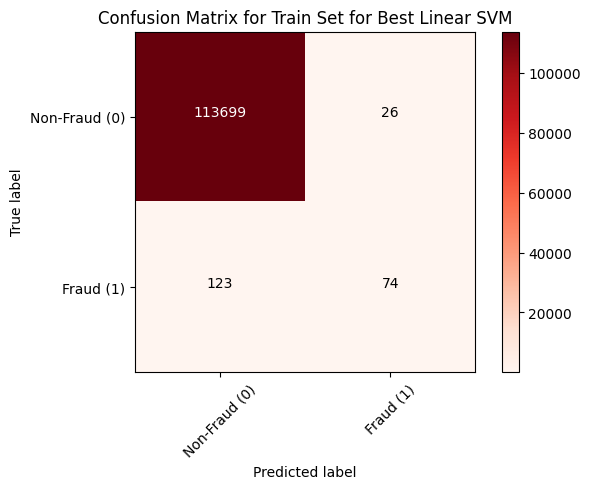

In [26]:
# Tahminler
best_linear_model_y_train_pred = (best_linear_model.predict(X_train) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_train, best_linear_model_y_train_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Confusion Matrix for Train Set for Best Linear SVM')

# Performans Değerleri
best_linear_train_results_df = get_model_results(y_train, best_linear_model_y_train_pred, 'Train', 'Best Linear SVM')
all_svm_results_df = pd.DataFrame()
all_svm_results_df = pd.concat([all_svm_results_df, best_linear_train_results_df], ignore_index=True)

display(best_linear_train_results_df)

Confusion matrix, without normalization
[[28424     8]
 [   29    20]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best Linear SVM,Test,99.87%,0.714,0.408,0.519


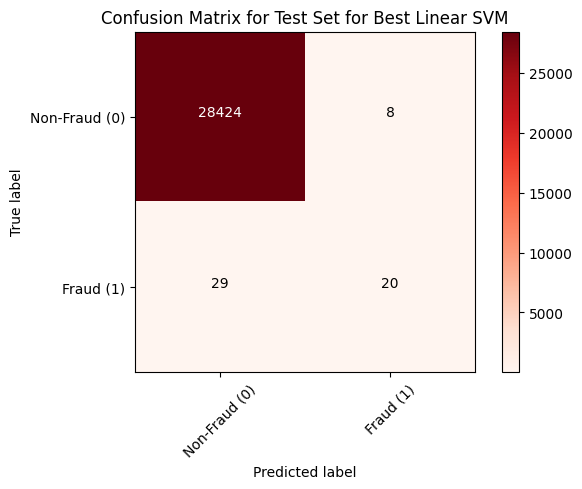

In [25]:
# Tahminler
best_linear_model_y_test_pred = (best_linear_model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, best_linear_model_y_test_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Confusion Matrix for Test Set for Best Linear SVM')

# Performans Değerleri
best_linear_test_results_df = get_model_results(y_test, best_linear_model_y_test_pred, 'Test', 'Best Linear SVM')
all_svm_results_df = pd.concat([all_svm_results_df, best_linear_test_results_df], ignore_index=True)

display(best_linear_test_results_df)

## Performance Metrics for the Best Polynomial Kernel Model

En iyi polinomsal kernel için confusion matrix i ve performance metriklerini hesaplayalım.

Confusion matrix, without normalization
[[113725      0]
 [   197      0]]


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best Polynomial SVM,Train,99.83%,0.000,0.000,0.000


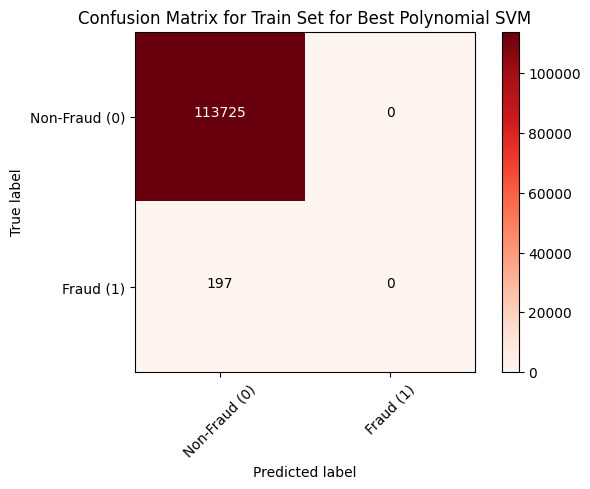

In [24]:
# Tahminler
best_poly_model_y_train_pred = (best_poly_model.predict(X_train) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_train, best_poly_model_y_train_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Confusion Matrix for Train Set for Best Polynomial SVM')

# Performans Değerleri
best_poly_train_results_df = get_model_results(y_train, best_poly_model_y_train_pred, 'Train', 'Best Polynomial SVM')
all_svm_results_df = pd.concat([all_svm_results_df, best_poly_train_results_df], ignore_index=True)

display(best_poly_train_results_df)

Confusion matrix, without normalization
[[28432     0]
 [   49     0]]


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best Polynomial SVM,Test,99.83%,0.000,0.000,0.000


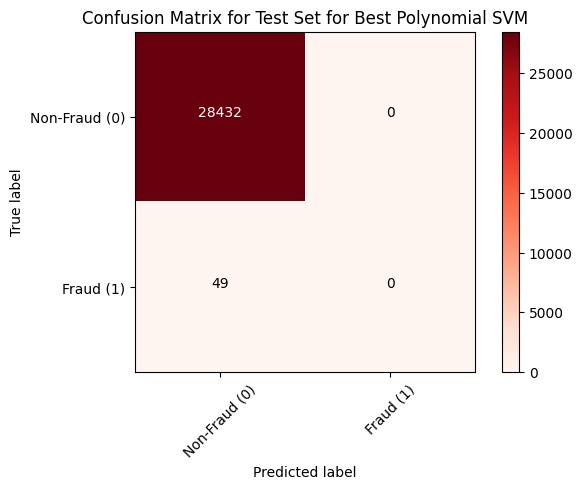

In [27]:
# Tahminler
best_poly_model_y_test_pred = (best_poly_model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, best_poly_model_y_test_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Confusion Matrix for Test Set for Best Polynomial SVM')

# Performans Değerleri
best_poly_test_results_df = get_model_results(y_test, best_poly_model_y_test_pred, 'Test', 'Best Polynomial SVM')
all_svm_results_df = pd.concat([all_svm_results_df, best_poly_test_results_df], ignore_index=True)

display(best_poly_test_results_df)

## Performance Metrics for the Best Gaussian RBF Kernel Model

Gaussion RBF kernel için confusion matrix i ve performance metriklerini hesaplayalım.

Confusion matrix, without normalization
[[113725      0]
 [    58    139]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best RBF SVM,Train,99.95%,1.000,0.706,0.827


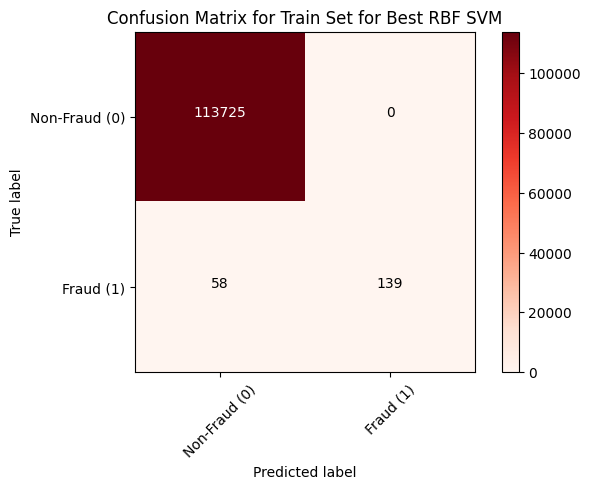

In [28]:
# Tahminler
best_rbf_model_y_train_pred = (best_rbf_model.predict(X_train) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_train, best_rbf_model_y_train_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Confusion Matrix for Train Set for Best RBF SVM')

# Performans Değerleri
best_rbf_train_results_df = get_model_results(y_train, best_rbf_model_y_train_pred, 'Train', 'Best RBF SVM')
all_svm_results_df = pd.concat([all_svm_results_df, best_rbf_train_results_df], ignore_index=True)

display(best_rbf_train_results_df)

Confusion matrix, without normalization
[[28432     0]
 [   48     1]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best RBF SVM,Test,99.83%,1.000,0.020,0.040


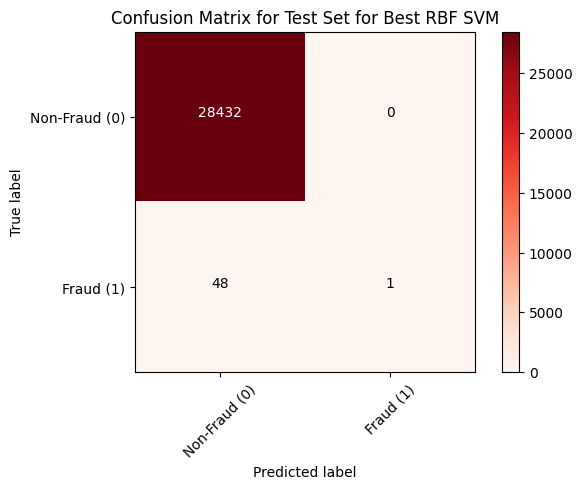

In [29]:
# Tahminler
best_rbf_model_y_test_pred = (best_rbf_model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, best_rbf_model_y_test_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Confusion Matrix for Test Set for Best RBF SVM')

# Performans Değerleri
best_rbf_test_results_df = get_model_results(y_test, best_rbf_model_y_test_pred, 'Test', 'Best RBF SVM')
all_svm_results_df = pd.concat([all_svm_results_df, best_rbf_test_results_df], ignore_index=True)

display(best_rbf_test_results_df)

# Tüm Sonuçlar Üzerinde Karşılaştırma

Tüm sonuçların tablolaştırılmış hali aşağıdaki gibidir.
* Sonuçlara bakılırsa bu imbalance dataset üzerinde en iyi sonuçları linear kernel ile elde ediyoruz.
* Polynomial kernel hiç fit olmamış.
* Gaussian RBF kernel ise train set üzerinde çok yüksek başarı vermiş ama test setinde düşük başarı vermiştir. Bu nedenle overfitting olmuş diyebiliriz.

In [23]:
display(all_svm_results_df)

,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best Linear SVM,Train,99.87%,0.740,0.376,0.498
1,Best Linear SVM,Test,99.87%,0.714,0.408,0.519
2,Best Polynomial SVM,Train,99.83%,0.000,0.000,0.000
3,Best Polynomial SVM,Test,99.83%,0.000,0.000,0.000
4,Best RBF SVM,Train,99.95%,1.000,0.706,0.827
5,Best RBF SVM,Test,99.83%,1.000,0.020,0.040


# References

* https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets